# Abstract

Insert here

# Data

We are diving into a [Credit Risk Dataset](https://www.kaggle.com/datasets/laotse/credit-risk-dataset) that simulates credit bureau data.

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

Here is a first look at the raw data:

In [2]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


I want to highlight several important features of this dataset.

* `loan_percent_income` is ratio of the loan amount to the individual's income
* `loan_int_rate` is the annual interest rate on the loan.
* `loan_status` tells us whether or not the individual defaulted on their loan. This a a binary feature where `0` indicates the individual **defaulted**, and `1` indicates the loan was **repaid** in full. This is our **Target Variable**.

Lets have a look at how common defaulting is in our training data:

In [3]:
df_train["loan_status"].value_counts(normalize=True)

loan_status
0    0.78242
1    0.21758
Name: proportion, dtype: float64

In the dataset, around 21% of borrowers default on their loan. This is going to be the our *base rate for prediction*.

In [4]:
df_train["person_age"].describe()

count    26064.000000
mean        27.734385
std          6.362612
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: person_age, dtype: float64

There seems to be some slight errors in our data with the age of certain individuals. 144, although impressive, is highly unlikely. Thus, without context for why the data has such an outlier, I am going to filter our data to exclude persons over 100 years old. In addition, I will do some other data cleaning like removing NaN entries, one-hot encoding qualitative features, etc.

In [5]:
df_train = df_train[df_train["person_age"] < 100]

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df_train["cb_person_default_on_file"])

df_train["cb_person_default_on_file"] = le.transform(df_train["cb_person_default_on_file"])

df_train = df_train.dropna()

In [7]:
df_train.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,1,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,0,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,0,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,0,10
6,21,21700,RENT,2.0,HOMEIMPROVEMENT,D,5500,14.91,1,0.25,0,2


# Exploration

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

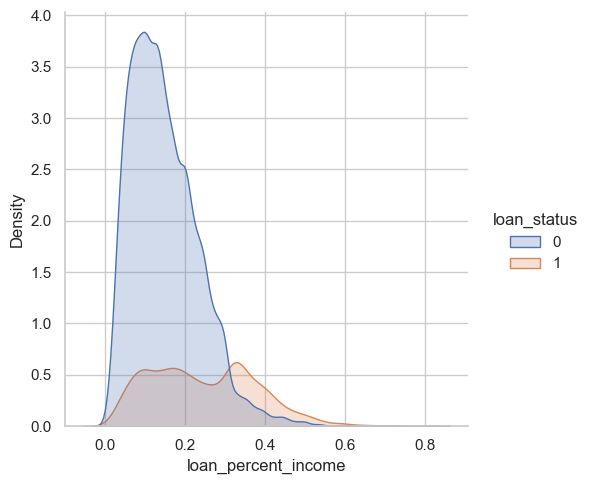

In [9]:
sns.displot(data=df_train, x="loan_percent_income", hue="loan_status", kind="kde", bw_adjust=0.9, fill=True, alpha=0.25)

Kernel Density Estimation (KDE)

<Axes: xlabel='cb_person_cred_hist_length', ylabel='loan_int_rate'>

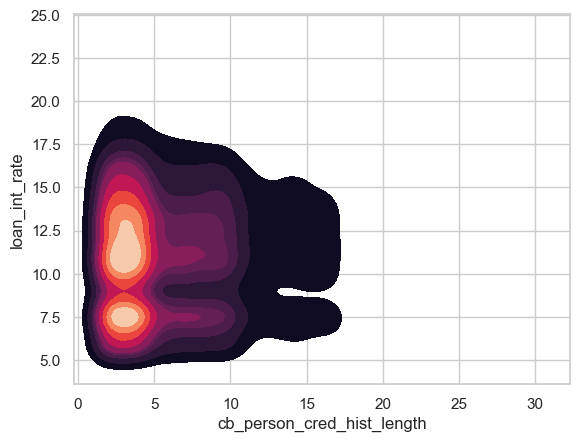

In [10]:
sns.kdeplot(data=df_train, x="cb_person_cred_hist_length", y="loan_int_rate", cmap="rocket", fill=True)

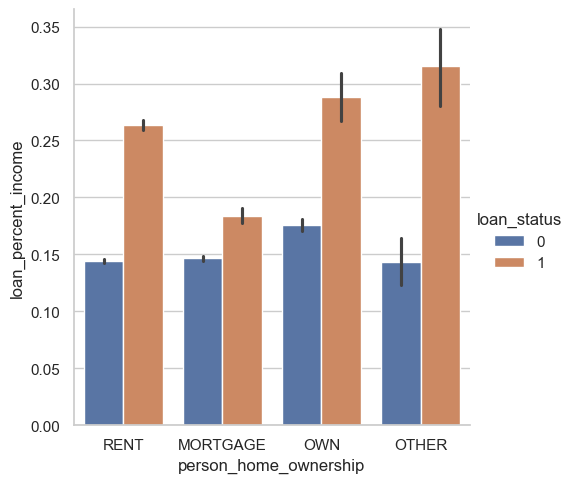

In [11]:
sns.catplot(data=df_train, kind="bar", x="person_home_ownership", y="loan_percent_income", hue="loan_status")

In [12]:
import numpy as np

bins = [0, 5, 10, 15, 20, np.inf]
labels = ['0-5', '5-10', '10-15', '15-20', '20+']

df_train.groupby(
    pd.cut(df_train['cb_person_cred_hist_length'], bins=bins, labels=labels), observed=True
)[['person_age', 'person_emp_length']].agg(['mean'])

,person_age,person_emp_length
,mean,mean
cb_person_cred_hist_length,,
0-5,24.253351,4.277778
5-10,29.975727,5.417458
10-15,40.011823,5.982576
15-20,41.297771,6.046178
20+,57.318471,5.923567


# Model Building

In [ ]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


all_qual_cols = ["person_home_ownership", "loan_intent"]
all_quant_cols = ["person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "cb_person_default_on_file"]

df_train = pd.get_dummies(df_train)

LR = LogisticRegression()
scaler = StandardScaler()

df_train[all_quant_cols] = scaler.fit_transform(df_train[all_quant_cols])
score = 0
final_cols = []

X_train = df_train.drop(columns = "loan_status")
y_train = df_train["loan_status"]

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    LR.fit(X_train[cols], y_train)
    cross_val_scores = cross_val_score(LR, X_train[cols], y_train, cv = 10)
    if cross_val_scores.mean() > score:
      score = cross_val_scores.mean()
      final_cols = cols

print(f"The best model scored {score*100:.3f}% accuracy when testing on training data using: \n{final_cols}")    

The best model scored 84.70% accuracy when testing on training data using: 
['person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'person_emp_length', 'loan_percent_income']


In [14]:
def linear_score(X, w):
    return X@w

In [15]:
LR.coef_

array([[ 0.18842993, -0.48205777,  0.05292144,  0.09120963, -0.32595954,
        -0.66665595, -0.0635448 ,  0.38708015]])

In [16]:
w = np.array(LR.coef_[0][2:])
s = linear_score(df_train[final_cols], w)

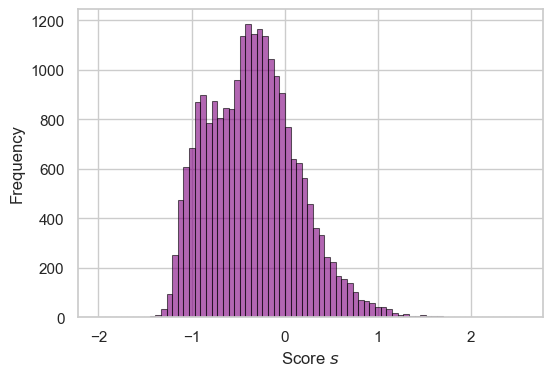

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
hist = ax.hist(s, bins = 75, color = "purple", alpha = 0.6, linewidth = 0.75, edgecolor = "black")
labs = ax.set(xlabel = r"Score $s$", ylabel = "Frequency") 

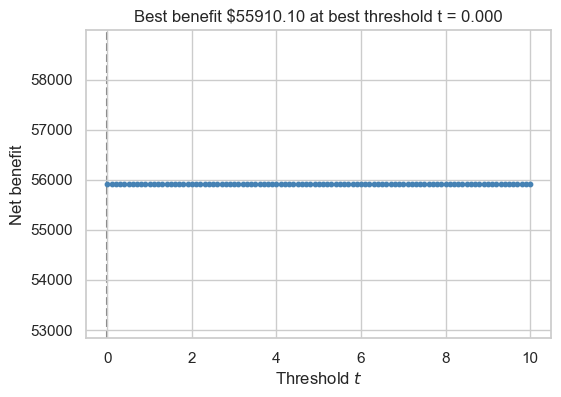

In [ ]:
best_profit = 0
best_threshold = 0



fig, ax = plt.subplots(1, 1, figsize = (6, 4))
for t in np.linspace(0, 10, 101): 
    y_pred = s >= t
    tn = ((y_pred == 0) & (y_train == 0)).mean()
    fn = ((y_pred == 0) & (y_train == 1)).mean()

    profit = ((df_train["loan_amnt"]*(1 + 0.25*df_train["loan_int_rate"])**10) - df_train["loan_amnt"]).sum()
    loss = ((df_train["loan_amnt"]*(1 + 0.25*df_train["loan_int_rate"])**3) - (1.7*df_train["loan_amnt"])).sum()  

    net_profit = profit*tn - loss*fn
    ax.scatter(t, net_profit, color = "steelblue", s = 10)
    if net_profit > best_profit: 
        best_profit = net_profit
        best_threshold = t

ax.axvline(best_threshold, linestyle = "--", color = "grey", zorder = -10)
labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Net benefit", title = f"Best benefit ${best_profit:.2f} at best threshold t = {best_threshold:.3f}")